In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [16]:
def bonos_dbAlgebra(n,cn):
    bonos = "SELECT TOP(" + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt, bono.Nemotecnico AS Nemotecnico FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo,  [dbPortFolio].[dbo].[TdPlanvitalCartera] AS planvital WHERE bono.Nemotecnico = riesgo.Nemotecnico AND bono.FechaEmision > '20190101' AND bono.Nemotecnico = planvital.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 2, 1)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(1,cn))
bonos

,Moneda,TablaDesarrollo,Base1,Base2,FechaEmision,RiesgoInt,Nemotecnico,Convencion,Riesgo
0,UF,1#01-08-2019#1#0#100#1|2#01-02-2020#1#0#100#1|...,ACT,365,2019-02-01,1,BBCII10219,ACT/365,AAA


In [17]:
derivados = derivados_dBDerivados(5, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-02-01,2020-05-12,2020-05-12,2020-05-12,2.084130e+08,2.000734e+08,CLP,CLP
1,1368,-1,2019-02-01,2020-11-12,2020-11-12,2020-11-12,9.091985e+07,8.572294e+07,CLP,CLP
2,1368,-1,2019-02-01,2021-05-12,2021-05-12,2021-05-12,9.095391e+07,8.422297e+07,CLP,CLP
3,1368,-1,2019-02-01,2021-11-12,2021-11-12,2021-11-12,5.095861e+09,4.629981e+09,CLP,CLP
4,1368,1,2019-02-01,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.506090e+07,CLP,CLP
5,1368,1,2019-02-01,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.481454e+07,CLP,CLP
6,1368,1,2019-02-01,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.363304e+07,CLP,CLP
7,1368,1,2019-02-01,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.576433e+09,CLP,CLP


In [18]:
acciones = historico("DE000DWS2D90", "A", 60)


{1: {('Renta Variable Extranjera', 'Accion'): 12187720060.0, ('Renta Fija Nacional ', 'Bono', 'AAA'): array([5.04210593e-01, 6.88453152e-01, 1.61537937e-01, 8.95913826e-02,
       4.02106328e-02, 1.35518725e-02, 4.94275220e-03, 1.39897492e-03,
       3.60524296e-04, 1.37565273e-04, 5.67130196e-05, 2.29626565e-05,
       9.51152676e-06, 3.84917886e-06, 1.64164396e-06, 8.51613993e-07,
       2.54491482e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), ('Derivados', 'Derivado'): array([6.77595619e+10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000

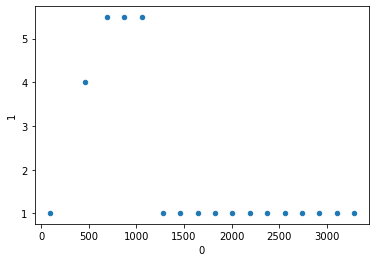

In [19]:
cartera = Cartera(acciones, bonos, derivados,'CLP', datetime.date(2019,2,1), cn, 60)

In [20]:
print(cartera.get_historicos_totales())

UF#90#AAA  UF#454#AAA  UF#682#AAA  UF#860#AAA  UF#1042#AAA  UF#1260#AAA  \
0    1.017365    1.090730    1.139355    1.178818     1.220582     1.272518   
1    1.017406    1.090947    1.139695    1.179254     1.221115     1.273164   
2    1.016997    1.088749    1.136285    1.174808     1.215528     1.266059   
3    1.016951    1.088491    1.135844    1.174157     1.214603     1.265010   
4    1.016936    1.088376    1.135532    1.173744     1.214123     1.264367   
5    1.016821    1.087788    1.134741    1.172811     1.213066     1.263067   
6    1.016758    1.087457    1.134264    1.172176     1.212234     1.261987   
7    1.016869    1.088048    1.135148    1.173333     1.213704     1.263892   
8    1.016912    1.088278    1.135509    1.173803     1.214293     1.219083   
9    0.997404    0.983576    0.971621    0.963504     0.955979     0.946969   
10   0.997236    0.980192    0.970442    0.962845     0.955102     0.945900   
11   0.997293    0.981719    0.972552    0.965440     0.

In [21]:
print(cartera.get_retornos_totales())

UF#90#AAA  UF#454#AAA  UF#682#AAA  UF#860#AAA  UF#1042#AAA  UF#1260#AAA  \
0    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000   
1    0.000136    0.000296    0.000396    0.000467     0.000534     0.000604   
2   -0.000112   -0.001728   -0.002707   -0.003488    -0.004297    -0.005307   
3    0.000052   -0.000140   -0.000292   -0.000458    -0.000664    -0.000732   
4    0.000082   -0.000009   -0.000178   -0.000255    -0.000299    -0.000412   
5   -0.000017   -0.000444   -0.000600   -0.000699    -0.000774    -0.000932   
6    0.000034   -0.000207   -0.000324   -0.000445    -0.000590    -0.000759   
7    0.000400    0.000833    0.001069    0.001276     0.001502     0.001798   
8    0.000139    0.000308    0.000414    0.000497     0.000582    -0.036000   
9   -0.019274   -0.101061   -0.155774   -0.197331    -0.239084    -0.252491   
10  -0.000072   -0.003350   -0.001118   -0.000588    -0.000822    -0.001033   
11   0.000154    0.001654    0.002269    0.002789     0.

In [22]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.0008461944529046615


In [23]:
cartera.get_historicos_totales()

,UF#90#AAA,UF#454#AAA,UF#682#AAA,UF#860#AAA,UF#1042#AAA,UF#1260#AAA,UF#1441#AAA,UF#1620#AAA,UF#1801#AAA,UF#1981#AAA,...,CLP#1801,CLP#1981,CLP#2162,CLP#2341,CLP#2522,CLP#2701,CLP#2882,CLP#3061,CLP#3242,DE000DWS2D90
0,1.017365,1.090730,1.139355,1.178818,1.220582,1.272518,1.317295,1.363077,1.410966,1.460128,...,0.888651,0.872290,0.855906,0.839332,0.822743,0.806185,0.789649,0.773316,0.757044,0.000000
1,1.017406,1.090947,1.139695,1.179254,1.221115,1.273164,1.318031,1.363837,1.411730,1.461167,...,0.889949,0.874108,0.858205,0.841853,0.825439,0.808881,0.792299,0.776044,0.759885,-0.011984
2,1.016997,1.088749,1.136285,1.174808,1.215528,1.266059,1.309553,1.354175,1.400843,1.448718,...,0.890739,0.875131,0.859473,0.843021,0.826437,0.810178,0.794017,0.777773,0.761500,-0.025392
3,1.016951,1.088491,1.135844,1.174157,1.214603,1.265010,1.308481,1.352821,1.399160,1.446794,...,0.891990,0.876382,0.860620,0.844379,0.828051,0.811733,0.795431,0.779192,0.762975,0.004143
4,1.016936,1.088376,1.135532,1.173744,1.214123,1.264367,1.307665,1.351908,1.398154,1.445681,...,0.892881,0.877462,0.861904,0.845906,0.829826,0.813491,0.797098,0.781029,0.765053,0.011249
5,1.016821,1.087788,1.134741,1.172811,1.213066,1.263067,1.306128,1.350124,1.396103,1.443351,...,0.892850,0.877677,0.862431,0.846397,0.830205,0.813739,0.797211,0.780959,0.764786,-0.000456
6,1.016758,1.087457,1.134264,1.172176,1.212234,1.261987,1.304825,1.348592,1.393760,1.383939,...,0.893066,0.878020,0.862903,0.847059,0.831086,0.814701,0.798216,0.782164,0.766235,-0.002001
7,1.016869,1.088048,1.135148,1.173333,1.213704,1.263892,1.306629,1.298669,1.279710,1.269984,...,0.893297,0.878384,0.863420,0.847478,0.831356,0.814770,0.798091,0.781908,0.765871,0.001982
8,1.016912,1.088278,1.135509,1.173803,1.214293,1.219083,1.203211,1.197238,1.183939,1.176878,...,0.893448,0.878558,0.863591,0.847654,0.831516,0.814897,0.798174,0.781986,0.765954,-0.002755
9,0.997404,0.983576,0.971621,0.963504,0.955979,0.946969,0.939523,0.932210,0.924860,0.917601,...,0.894320,0.879403,0.864371,0.848215,0.831828,0.815368,0.798900,0.782873,0.766972,0.013602


In [24]:
cartera.get_correlacion()

,UF#90#AAA,UF#454#AAA,UF#682#AAA,UF#860#AAA,UF#1042#AAA,UF#1260#AAA,UF#1441#AAA,UF#1620#AAA,UF#1801#AAA,UF#1981#AAA,...,CLP#1801,CLP#1981,CLP#2162,CLP#2341,CLP#2522,CLP#2701,CLP#2882,CLP#3061,CLP#3242,DE000DWS2D90
UF#90#AAA,1.000000,0.996009,0.998281,0.984485,0.920670,0.841227,0.757691,0.700076,0.630749,0.582650,...,-0.253416,-0.240880,-0.225914,-0.229218,-0.234975,-0.212689,-0.184998,-0.180252,-0.180637,0.273974
UF#454#AAA,0.996009,1.000000,0.995553,0.976146,0.905517,0.823011,0.738002,0.679110,0.608655,0.559052,...,-0.261757,-0.249815,-0.235226,-0.238495,-0.244040,-0.220928,-0.192263,-0.187514,-0.188105,0.279901
UF#682#AAA,0.998281,0.995553,1.000000,0.988749,0.928248,0.851448,0.769902,0.713916,0.646145,0.598907,...,-0.256181,-0.244012,-0.229483,-0.233296,-0.239564,-0.217326,-0.189569,-0.184286,-0.183994,0.275434
UF#860#AAA,0.984485,0.976146,0.988749,1.000000,0.973338,0.919188,0.853268,0.806788,0.748093,0.706878,...,-0.276184,-0.265478,-0.252807,-0.257559,-0.264594,-0.246262,-0.222735,-0.217731,-0.216471,0.233950
UF#1042#AAA,0.920670,0.905517,0.928248,0.973338,1.000000,0.983364,0.944643,0.914727,0.872464,0.842071,...,-0.299151,-0.291334,-0.282193,-0.288115,-0.295891,-0.284435,-0.268511,-0.264337,-0.261817,0.157833
UF#1260#AAA,0.841227,0.823011,0.851448,0.919188,0.983364,1.000000,0.988374,0.972007,0.943550,0.922295,...,-0.315260,-0.309509,-0.302880,-0.309800,-0.318279,-0.312121,-0.302002,-0.298483,-0.295037,0.099739
UF#1441#AAA,0.757691,0.738002,0.769902,0.853268,0.944643,0.988374,1.000000,0.994746,0.977893,0.964340,...,-0.322734,-0.318659,-0.314052,-0.321689,-0.330635,-0.328689,-0.323213,-0.320246,-0.316124,0.053653
UF#1620#AAA,0.700076,0.679110,0.713916,0.806788,0.914727,0.972007,0.994746,1.000000,0.994161,0.985651,...,-0.325361,-0.323007,-0.320377,-0.328790,-0.338281,-0.339014,-0.336469,-0.333396,-0.328281,0.022931
UF#1801#AAA,0.630749,0.608655,0.646145,0.748093,0.872464,0.943550,0.977893,0.994161,1.000000,0.996991,...,-0.324228,-0.323706,-0.323185,-0.332288,-0.342212,-0.345781,-0.346385,-0.343273,-0.337205,-0.009937
UF#1981#AAA,0.582650,0.559052,0.598907,0.706878,0.842071,0.922295,0.964340,0.985651,0.996991,1.000000,...,-0.320468,-0.320979,-0.321672,-0.330847,-0.340677,-0.346025,-0.348698,-0.346138,-0.340200,-0.032373


In [25]:
cartera.get_covarianza()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,9.042354e-06,0.000050,0.000075,0.000084,0.000084,0.000085,0.000084,0.000085,0.000084,0.000084,...,-2.428855e-06,-2.527051e-06,-2.588195e-06,-2.747534e-06,-2.933049e-06,-2.806088e-06,-0.000003,-0.000003,-0.000003,6.554864e-06
1,5.005851e-05,0.000279,0.000417,0.000462,0.000462,0.000465,0.000453,0.000457,0.000448,0.000449,...,-1.394436e-05,-1.456686e-05,-1.497865e-05,-1.588933e-05,-1.693138e-05,-1.620090e-05,-0.000015,-0.000015,-0.000016,3.722139e-05
2,7.519266e-05,0.000417,0.000627,0.000702,0.000709,0.000721,0.000708,0.000720,0.000714,0.000722,...,-2.045289e-05,-2.132391e-05,-2.190010e-05,-2.329392e-05,-2.490930e-05,-2.388406e-05,-0.000022,-0.000022,-0.000023,5.489259e-05
3,8.390976e-05,0.000462,0.000702,0.000803,0.000841,0.000880,0.000888,0.000920,0.000935,0.000964,...,-2.495096e-05,-2.625211e-05,-2.730014e-05,-2.909995e-05,-3.113142e-05,-3.062495e-05,-0.000029,-0.000030,-0.000031,5.275920e-05
4,8.444459e-05,0.000462,0.000709,0.000841,0.000930,0.001014,0.001058,0.001123,0.001173,0.001235,...,-2.908334e-05,-3.100214e-05,-3.279345e-05,-3.503052e-05,-3.746419e-05,-3.806487e-05,-0.000038,-0.000039,-0.000040,3.830356e-05
5,8.548036e-05,0.000465,0.000721,0.000880,0.001014,0.001142,0.001227,0.001322,0.001406,0.001499,...,-3.395537e-05,-3.648877e-05,-3.899384e-05,-4.172992e-05,-4.464545e-05,-4.627551e-05,-0.000048,-0.000049,-0.000050,2.681580e-05
6,8.369753e-05,0.000453,0.000708,0.000888,0.001058,0.001227,0.001349,0.001471,0.001584,0.001704,...,-3.778779e-05,-4.083931e-05,-4.395366e-05,-4.710520e-05,-5.041800e-05,-5.297610e-05,-0.000055,-0.000057,-0.000058,1.568160e-05
7,8.472282e-05,0.000457,0.000720,0.000920,0.001123,0.001322,0.001471,0.001620,0.001764,0.001908,...,-4.173552e-05,-4.535224e-05,-4.912347e-05,-5.274560e-05,-5.651314e-05,-5.986150e-05,-0.000063,-0.000065,-0.000066,7.342629e-06
8,8.361914e-05,0.000448,0.000714,0.000935,0.001173,0.001406,0.001584,0.001764,0.001944,0.002114,...,-4.556023e-05,-4.978891e-05,-5.428420e-05,-5.839517e-05,-6.262686e-05,-6.688443e-05,-0.000071,-0.000073,-0.000075,-3.485667e-06
9,8.426468e-05,0.000449,0.000722,0.000964,0.001235,0.001499,0.001704,0.001908,0.002114,0.002313,...,-4.912569e-05,-5.385753e-05,-5.894189e-05,-6.342735e-05,-6.801389e-05,-7.301620e-05,-0.000078,-0.000081,-0.000082,-1.238779e-05
